<a href="https://colab.research.google.com/github/N3wBaz/MLzoomcamp/blob/main/hw4/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

In [29]:
df = pd.read_csv('AER_credit_card_data.csv')

In [30]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [31]:
df.card = (df.card == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

print(df_train.shape, df_test.shape, df_val.shape)

(791, 11) (264, 11) (264, 11)


## Q1

In [32]:
from sklearn.metrics import auc

In [33]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    for t in range(len(y_val)):
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    
    return df_scores


numerical = ['reports', 'dependents', 'active', 'share']
for i in numerical:
    # print(roc_auc_score(df_train[i] < df_train[i].mean(), y_train))
    tpr_fpr = tpr_fpr_dataframe(y_train, df_train[i])
    score = auc(tpr_fpr['fpr'], tpr_fpr['tpr'])
    if score < 0.5:
        score = 1 - score
    print(f"AUC {i}  :  {score}")


AUC reports  :  0.7166629860689376
AUC dependents  :  0.5327757227773791
AUC active  :  0.6043173411362006
AUC share  :  0.5


## Q2

In [34]:
numerical = ['reports', 'age','income','share','expenditure','dependents','months','majorcards','active']
categorical = ['owner','selfemp']

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [35]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5).astype(int)
tpr_fpr = tpr_fpr_dataframe(y_val, card_decision)
score = auc(tpr_fpr['fpr'], tpr_fpr['tpr'])
print(f"AUC on the validation dataset is {round(score, 3)}")


AUC on the validation dataset is 0.974


## Q3

In [36]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.fp + df_scores.tp)

    
    return df_scores
plot_score = tpr_fpr_dataframe(y_val, y_pred)


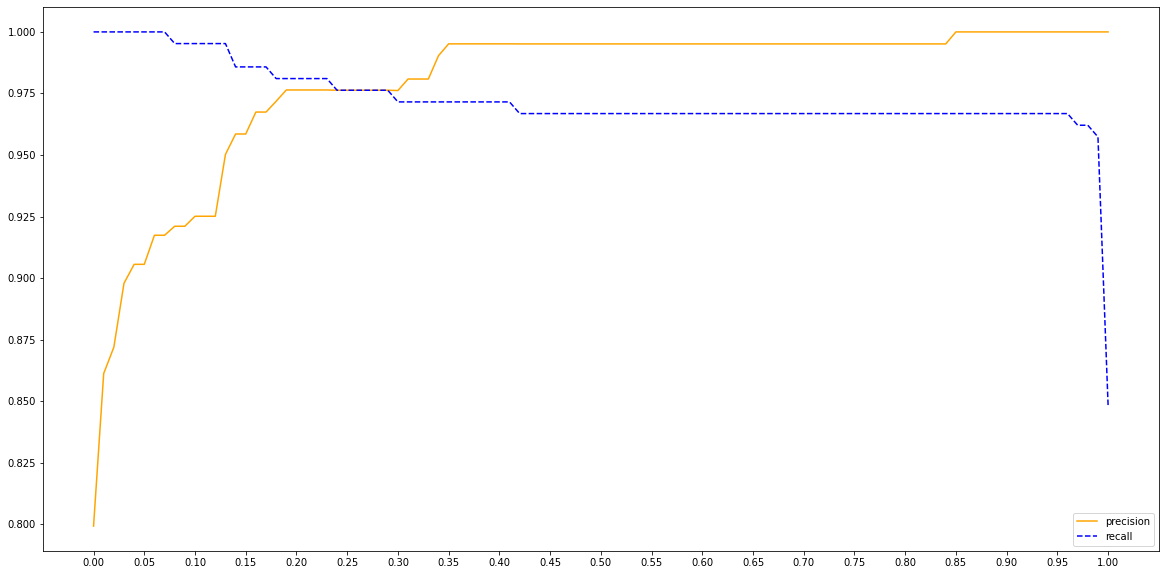

In [37]:
plt.figure(figsize=(20, 10))

plt.plot(plot_score['threshold'], plot_score['precision'], color='orange', linestyle='solid', label='precision')
plt.plot(plot_score['threshold'], plot_score['recall'], color='blue', linestyle='dashed', label='recall')
plt.xticks(np.linspace(0, 1, 21))
plt.legend()

In [38]:
print(f"Threshold precision and recall curves intersect at {plot_score['threshold'][plot_score['recall'] == plot_score['precision']].mean()}")

Threshold precision and recall curves intersect at 0.265


## Q4

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = [0.1, 0.4, 0.6, 0.7]

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.fp + df_scores.tp)
    return df_scores
data = tpr_fpr_dataframe(y_val, y_pred)

data['f1'] = 2 * data['precision'] * data['recall'] / (data['precision'] + data['recall'])

In [40]:
data

,threshold,tp,fp,fn,tn,tpr,fpr,recall,precision,f1
0,0.1,210,17,1,36,0.995261,0.320755,0.995261,0.925110,0.958904
1,0.4,205,1,6,52,0.971564,0.018868,0.971564,0.995146,0.983213
2,0.6,204,1,7,52,0.966825,0.018868,0.966825,0.995122,0.980769
3,0.7,204,1,7,52,0.966825,0.018868,0.966825,0.995122,0.980769


In [41]:
data['f1'].argmax()

1

In [42]:
print(f"Threshold F1 is maximal at {data.iloc[data['f1'].argmax()]['threshold']}")

Threshold F1 is maximal at 0.4


## Q5


In [43]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

dv, model = train(df_train, y_train, C=0.001)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


y_pred = predict(df_val, dv, model)

aucs = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)


In [44]:
aucs

[0.9943244739756367,
 0.9944852941176471,
 0.9938076416337287,
 0.9997405293201868,
 1.0]

In [45]:
print(f"Standard deviation :  {round(np.array(aucs).std(), 3)}")

Standard deviation :  0.003


## Q6

In [46]:
# def train(df, y, C=1.0):
#     cat = df[features].to_dict(orient='records')
    
#     dv = DictVectorizer(sparse=False)
#     dv.fit(cat)

#     X = dv.transform(cat)

#     model = LogisticRegression(solver='liblinear', C=C)
#     model.fit(X, y)

#     return dv, model

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


In [47]:
for C in [0.01, 0.1, 1, 10]:
    aucs = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        
        
        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.995 ± 0.004
C=0.1, auc = 0.997 ± 0.003
C=1, auc = 0.996 ± 0.003
C=10, auc = 0.997 ± 0.003
